# Modeling

In [1]:
# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

# transform
import numpy as np
import pandas as pd

# visualize 
import matplotlib.pyplot as plt
import seaborn as sns

# working with dates
from datetime import datetime

# modeling
import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing

# evaluate
from sklearn.metrics import mean_squared_error
from math import sqrt 

import math

In [2]:
# load data from existing csv
train = pd.read_csv("./00_project_data/1-1_training_data.csv", index_col=0)
validate = pd.read_csv("./00_project_data/1-2_validation_data.csv", index_col=0)
train.head()

,zipcode,bite
dateofbite,,
2015-01-01,NaN,1
2015-01-01,11220,1
2015-01-01,10026,1
2015-01-01,11221,1
2015-01-01,NaN,1


**Final cleaning**

In [3]:
# covert the index to datetime
train.index = train.index.astype("datetime64")
validate.index = validate.index.astype("datetime64")

In [4]:
train = train.resample('D').bite.sum()
validate = validate.resample('D').bite.sum()
train = pd.DataFrame(train)
validate = pd.DataFrame(validate)

train.head()

,bite
dateofbite,
2015-01-01,7
2015-01-02,9
2015-01-03,7
2015-01-04,11
2015-01-05,5


**Visulize train and validate**

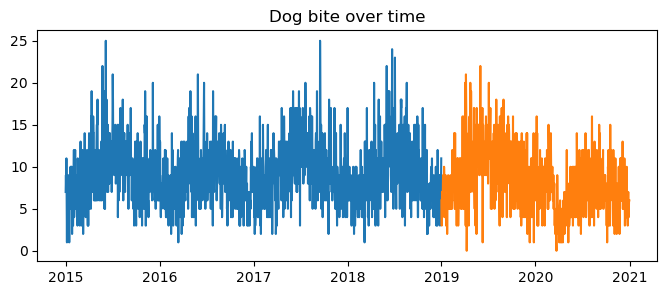

In [5]:
# plt the value value fof bite over time
plt.figure(figsize=(8,3))
plt.plot(train.bite)
plt.plot(validate.bite)
plt.title("Dog bite over time")
plt.show()

**Create an evaluation function**

evaluate() will compute the Mean Squared Error and the Rood Mean Squared Error to evaluate.

In [6]:
# evaluation funtion
def evaluate(target):
    """
    Takes in the target col name and return the root mean square error for
    the validate/test against the predicted values.
    """
    rmse = round(sqrt( # get root mean square error
        mean_squared_error(validate[target], y_pred_df[target])), 2) # get mean squared error
    return rmse
    

**Plot evaluation funtion**

In [7]:
# plot predictions vs actual values
def plot_evaluate(target):
    """
    Function will return a plot of the predicted values against the actual values in the data.
    """
    # plt.ioff()
    # plt the value value fof bite over time and the predicted
    plt.figure(figsize=(8,3))
    plt.plot(train.bite, label="Train", linewidth=1)
    plt.plot(validate.bite,label="Validate", linewidth=1)
    plt.plot(y_pred_df[target],label="Prediction", linewidth=1 )
    plt.title("Dog bite over time prediction")
    
    rmse = evaluate(target)
    print(target, f'-- rmse: {round(rmse,2)}')
    plt.legend()

**Evaluation data frame**

In [8]:
# create evaluation dataframe
eval_df = pd.DataFrame(columns=["model", "target", "rmse"])
eval_df

,model,target,rmse


In [9]:
# function to append to the evaluation dataframe
def append_to_eval(model, target):
    """
    Function append the current running model results the historical models.
    """
    rmse = evaluate(target)
    res_dict = pd.DataFrame({"model":[model],
               "target": [target],
               "rmse":[rmse]})
    return pd.concat([eval_df, res_dict])

## Baseline model (Moving Average)

I will use a iterating day lag moving average to forecast.

In [10]:
# looking at 2% of the validation data
lags = math.ceil(validate.shape[0] * .3)

for i in range(1, lags + 1):
    # get the average over a lot of different days
    rolling_quantity = round(train.bite.rolling(i).mean()[-1],2)
    
    # predict baseline over time
    y_pred_df = pd.DataFrame({"bite": rolling_quantity},
                             index=validate.index)
    
    # update the evaluate dataframe
    model_type = str(i) + '_day_moving_avg'
    eval_df= append_to_eval(model=model_type, target="bite")
    

In [25]:
eval_df.head(3)

,model,target,rmse
0,1_day_moving_avg,bite,4.71
0,2_day_moving_avg,bite,3.99
0,3_day_moving_avg,bite,3.78


**Plot actual vs predicted**

In [13]:
# plot_evaluate("bite")
# plt.show()

## Holt linear trend

In [14]:
# create object fit and predict
model = Holt(train["bite"], exponential=False, damped=True)
model = model.fit(optimized=True)

y_pred_values = model.predict(start=validate.index[0],
                            end= validate.index[-1])
y_pred_df["bite"] = round(y_pred_values, 3)

In [23]:
# no frequncy infomation provided so D is used
y_pred_df.head(1)

,bite
dateofbite,
2019-01-01,12.21067


**Add to evaluation dataframe**

In [17]:
eval_df = append_to_eval(model = 'holts_optimized', 
                            target= "bite")

In [24]:
eval_df.tail(3)

,model,target,rmse
0,220_day_moving_avg,bite,4.01
0,holts_optimized,bite,4.12
0,previous year,bite,5.16


## Holts seasonal trend

# Predict base on previous cycle

In [19]:
# Calculates the difference of a DataFrame element compared with another element
# period (lag) (must be th lenght of the validation season)
mean_diff = train.diff(periods=365 * 2).mean()
mean_diff

bite    0.21067
dtype: float64

In [20]:
# find the diff. add to each value in 2015.
y_pred_df = train['2016':'2017'] + mean_diff

# set yhat_df to index of validate
y_pred_df.index = validate.index

In [21]:
validate.head()

,bite
dateofbite,
2019-01-01,6
2019-01-02,3
2019-01-03,7
2019-01-04,4
2019-01-05,5


**Add to evaluation dataframe**

bite -- rmse: 5.16


,model,target,rmse
0,220_day_moving_avg,bite,4.01
0,holts_optimized,bite,4.12
0,previous year,bite,5.16


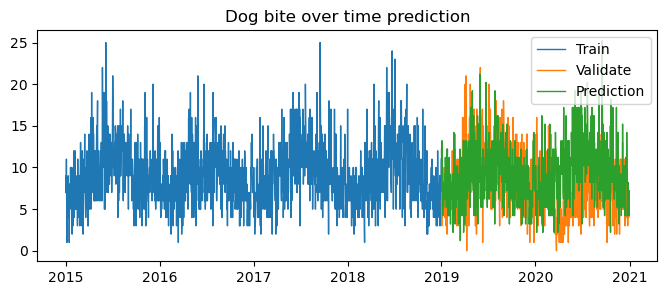

In [22]:
# add results to the evaluation dataframe
plot_evaluate(target= "bite")
eval_df = append_to_eval(model = 'previous year', target = "bite")
eval_df.tail(3)

## Best model

In [36]:
# reset the index
eval_df = eval_df.reset_index(drop=True)

In [45]:
# find best model
eval_df = eval_df.sort_values(by='rmse').head(5)

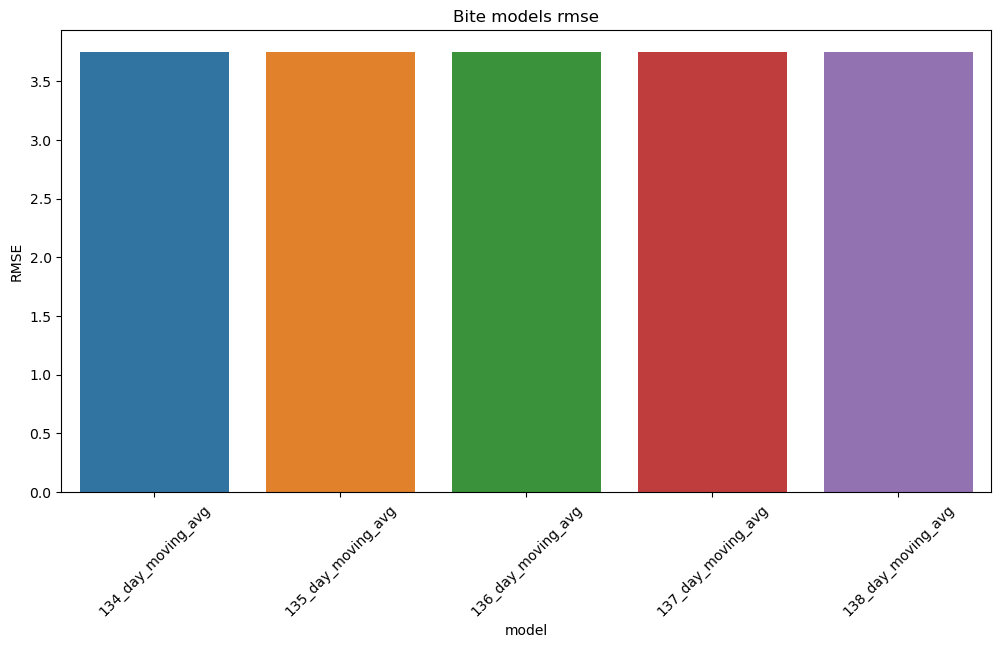

In [48]:

plt.figure(figsize=(12, 6))
sns.barplot(data= eval_df, x="model", y="rmse")
plt.title("Bite models rmse")
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.show()

## Test